# Image Frequency Scrambling

Inspired by a [Hacker News comment by crispyambulance](https://news.ycombinator.com/item?id=15932044):

```
Well, there's another neat thing that you can do if you want to generate an interesting 2D -> 2D representation:

* Take fourier transform of the image for each color R, G, B

* Randomly scramble the phase of the transformed image.

* Perform the fourier inverse of that scrambled phase image.

The result is another 2D image with the same colors AND spatial frequencies as the original image. It looks like you took the original photo and vaporized it into gas. Interesting.
```

I'll get [Lenna](https://en.wikipedia.org/wiki/Lenna) from Wikipedia as an example image.

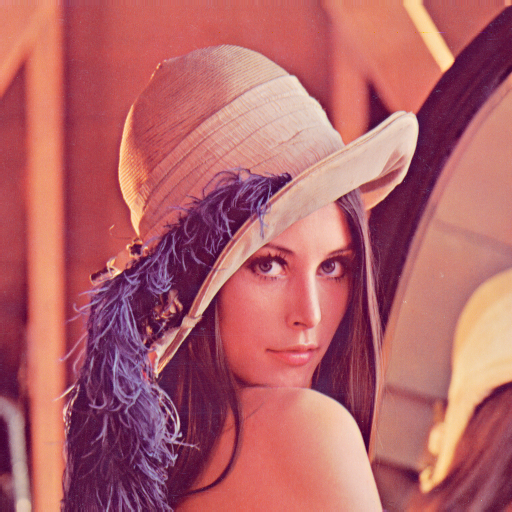

In [1]:
# shamelessly adapted from https://stackoverflow.com/a/12020860
from PIL import Image
import urllib.request
import io

fd = urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/en/2/24/Lenna.png")
image_file = io.BytesIO(fd.read())
image = Image.open(image_file)
image

Using NumPy to get the frequency spectrum.

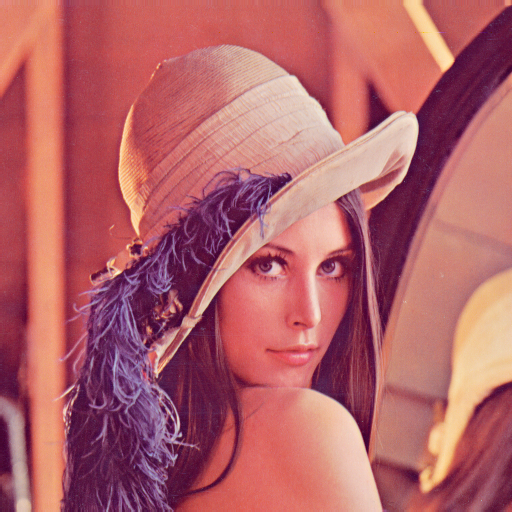

In [2]:
import numpy as np

def image_fft(image):
    return np.fft.fft2(image, axes=(0,1))

def image_ifft(array):
    return np.fft.ifft2(array, axes=(0,1))

def numpy_to_pillow(array):
    array = np.abs(array)
    maximum = np.max(array)
    if maximum > 255:
        array /= maximum / 255 # prevent clipping artifacts
    array = np.array(array, np.uint8)
    return Image.fromarray(array)

numpy_to_pillow(image_ifft(image_fft(image)))

Now mess with the phase.

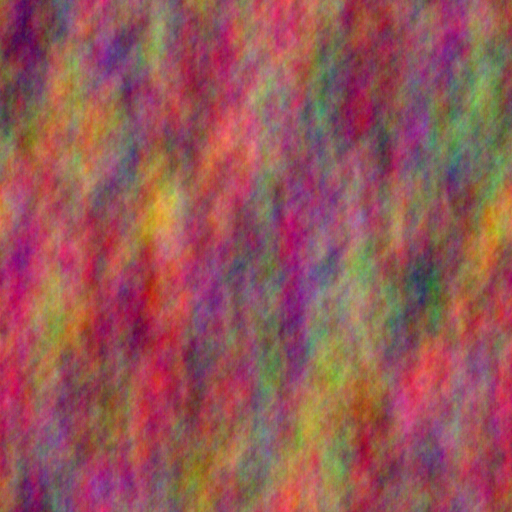

In [3]:
def random_phase_shift(array):
    noise = np.random.randn(*array.shape) + 1.j * np.random.randn(*array.shape)
    noise /= np.abs(noise) # normalize to avoid changing the magnitude
    return array * noise # multiplication by unit-magnitude complex numbers shifts the phase


numpy_to_pillow(image_ifft(random_phase_shift(image_fft(image))))

Ok, that's a bit underwhelming. What if the phase of all colors is shifted the same?

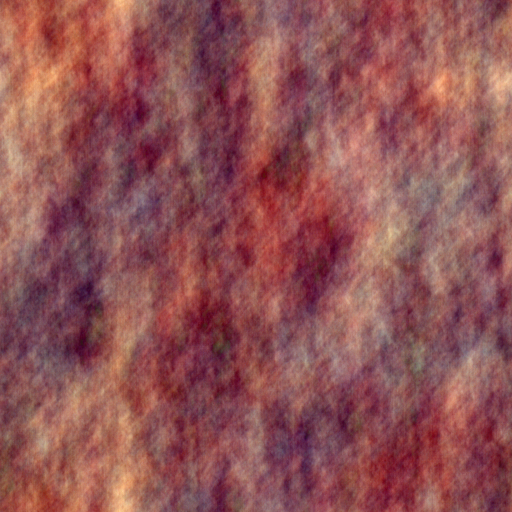

In [4]:
def random_colorfixed_phase_shift(array):
    noise = np.random.randn(*array.shape[:-1]) + 1.j * np.random.randn(*array.shape[:-1])
    noise /= np.abs(noise) # normalize to avoid changing the magnitude
    return array * np.expand_dims(noise, -1)  # multiplication by unit-magnitude complex numbers shifts the phase


numpy_to_pillow(image_ifft(random_colorfixed_phase_shift(image_fft(image))))

So this is the promised "vaporized" look.

## Bonus
What about changing the magnitude of the frequency spectrum and not the phase?

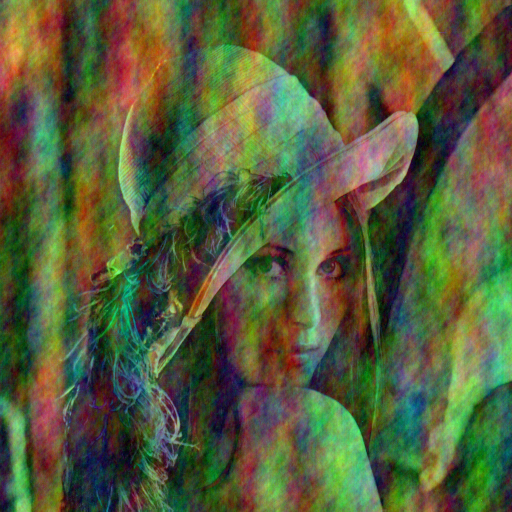

In [5]:
def random_magnitude_scaling(array):
    noise = np.exp(np.random.randn(*array.shape)) # using log-normal noise
    return array * noise

numpy_to_pillow(image_ifft(random_magnitude_scaling(image_fft(image))))

This shows that most of the "important" information of the image is actually in the phase.

Can we fix the color again?

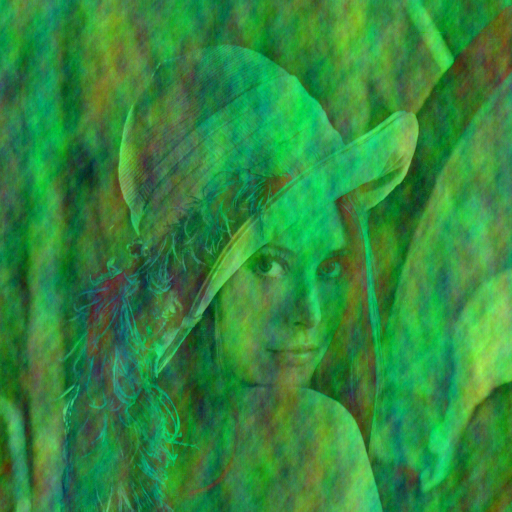

In [6]:
def random_colorfixed_magnitude_scaling(array):
    noise = np.exp(np.random.randn(*array.shape[:-1])) # using log-normal noise
    return array * np.expand_dims(noise, -1)

numpy_to_pillow(image_ifft(random_magnitude_scaling(image_fft(image))))

Not like this. It's actually fascinating that shifting the phase keeps the original palette while scaling the magnitude does not.